In [ ]:
# Bibliotecas
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2
from keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import kagglehub

In [ ]:
model = Sequential([
    Conv2D(32, (3, 3), input_shape=(600,600,3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),  # Aumentar o número de filtros
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu'),  # Aumentar o número de filtros
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(512, activation='relu', kernel_regularizer=l2(0.001)),  # Regularização L2
    Dropout(0.5),  # Camada de Dropout
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),  # Regularização L2
    Dropout(0.5),  # Camada de Dropout
    Dense(1, activation='sigmoid')  # Camada de saída para classificação binária
])

# Compile o modelo (exemplo de compilação)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 598, 598, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 299, 299, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 297, 297, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 148, 148, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 146, 146, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 73, 73, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 682112)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │     349,241,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 349,466,689 (1.30 GB)

 Trainable params: 349,466,689 (1.30 GB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Download do dataset sem especificar o caminho
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

print("Path to dataset files:", path)

100%|██████████| 2.29G/2.29G [01:49<00:00, 22.5MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2


In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   preprocessing_function=lambda x: tf.image.resize(x, (600,600)))
test_datagen = ImageDataGenerator(rescale=1./255,
                                  preprocessing_function=lambda x: tf.image.resize(x, (600,600)))
# Crie um callback de EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',     # O que monitorar (val_loss ou val_accuracy)
    patience=10,            # Número de épocas sem melhora antes de parar
    restore_best_weights=True # Restaura os melhores pesos após o treinamento
)

In [ ]:
train_generator = train_datagen.flow_from_directory(
        '/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/chest_xray/train',
        target_size=(600,600),
        batch_size=16,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        '/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/chest_xray/test',
        target_size=(600,600),
        batch_size=16,
        class_mode='binary')

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
import tensorflow as tf

model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(),metrics=['accuracy'])


# Treino
model.fit(train_generator,
          steps_per_epoch=len(train_generator) // 32,
          epochs=20,
          validation_data=validation_generator,
          callbacks=[early_stopping])

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10/10 ━━━━━━━━━━━━━━━━━━━━ 59s 3s/step - accuracy: 0.5064 - loss: 5.1805 - val_accuracy: 0.6250 - val_loss: 3.2946
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.7674 - loss: 3.1478 - val_accuracy: 0.6250 - val_loss: 3.4268
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 45s 5s/step - accuracy: 0.7613 - loss: 3.2573 - val_accuracy: 0.6635 - val_loss: 3.1621
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - accuracy: 0.8549 - loss: 2.7803 - val_accuracy: 0.8189 - val_loss: 2.6177
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 41s 5s/step - accuracy: 0.9096 - loss: 2.3110 - val_accuracy: 0.7035 - val_loss: 2.3027
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 28s 3s/step - accuracy: 0.8468 - loss: 1.9674 - val_accuracy: 0.6875 - val_loss: 1.8754
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 28s 3s/step - accuracy: 0.8481 - loss: 1.5210 - val_accuracy: 0.8301 - val_loss: 1.6135
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - accuracy: 0.7896 - loss: 1.4175 - val_accuracy: 0.7804 - val_loss: 1.4606
Epo

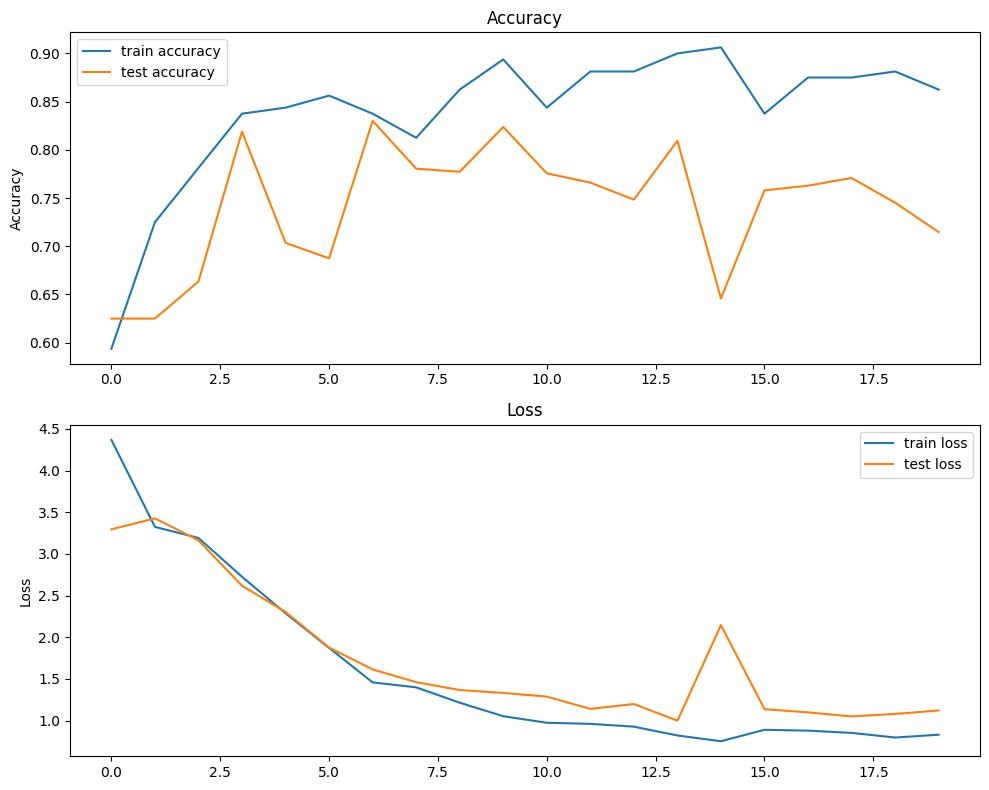

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

# Gráfico de precisão
axs[0].plot(model.history.history['accuracy'], label='train accuracy')
axs[0].plot(model.history.history['val_accuracy'], label='test accuracy')
axs[0].set_title('Accuracy')
axs[0].set_ylabel('Accuracy')
axs[0].legend()

# Gráfico de perda
axs[1].plot(model.history.history['loss'], label='train loss')
axs[1].plot(model.history.history['val_loss'], label='test loss')
axs[1].set_title('Loss')
axs[1].set_ylabel('Loss')
axs[1].legend()

plt.tight_layout()
plt.show()

In [ ]:
# Salve o modelo
model.save('pneumonia.h5')
model.save('pneumonia.weights.h5')